In [2]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
sys.path.append('../utils')
import operator_calculations as op_calc
import stats
plt.rc('text', usetex=True)
plt.rc('font',size=14)

In [3]:
#change path to where 'manuscript_data' is saved
dir_path = '/Users/costa/Repositories/max_pred_states_repo+data/manuscript_data/'

# top

In [11]:
k_B_T = 0.5
f = h5py.File(dir_path+'/DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
sim = np.array(f['simulation'])
T = np.array(f['MetaData/T'])[0]
discard_t = np.array(f['MetaData/discarded_t'])[0]
dt = np.array(f['MetaData/integration_step'])[0]
f.close()

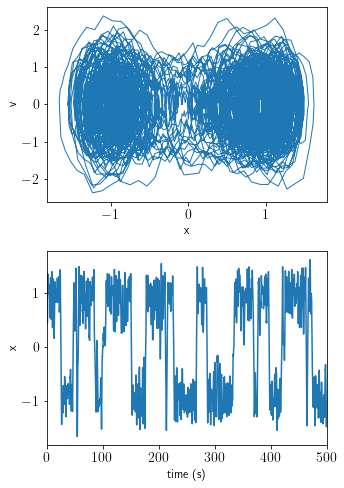

In [4]:
tmin = 0
tmax = 10000
plt.figure(figsize=(5,7))
plt.subplot(2,1,1)
plt.plot(sim[tmin:tmax,0],sim[tmin:tmax,1],alpha=1,lw=1)
plt.xlabel('x',fontsize=12)
plt.ylabel('v',fontsize=12)
plt.subplot(2,1,2)
plt.plot(np.arange(0,tmax*dt,dt),sim[:tmax,0])
plt.xlabel('time (s)',fontsize=12)
plt.ylabel('x',fontsize=12)
plt.xlim(0,500)
plt.tight_layout()
plt.show()

# middle 

In [5]:
f = h5py.File(dir_path+'/DoubleWell/combined_embedding_results.h5','r')
K_range = np.array(f['K_range'])
T_range = np.array(f['T_range'])
seed_range = np.array(f['seed_range'],dtype=int)[:15]
print(seed_range)
length = np.array(f['length'])[0]
prob_T_K_s = np.array(f['probs'])[:,:,:15,:]
H_T_K_s = np.array(f['entropies'])[:,:,:15,:]
h_T_K_s = np.array(f['entropy_rates'])[:,:,:15,:]
Ipred_T_K_s = np.array(f['Ipreds'])[:,:,:15,:]
eps_T_K_s = np.array(f['eps_scale'])
f.close()

[    3     5    10    17    31    56   100   177   316   562  1000  1778
  3162  5623 10000]


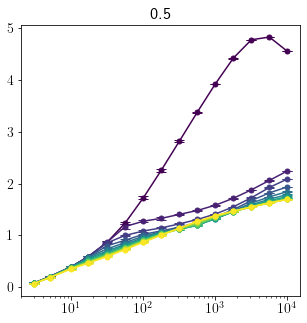

<Figure size 432x288 with 0 Axes>

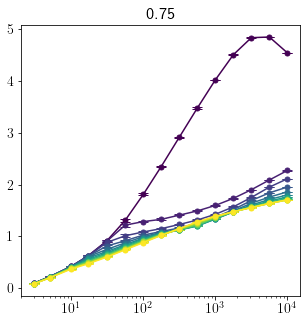

<Figure size 432x288 with 0 Axes>

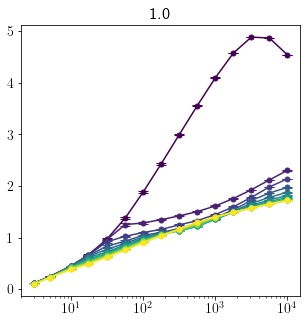

<Figure size 432x288 with 0 Axes>

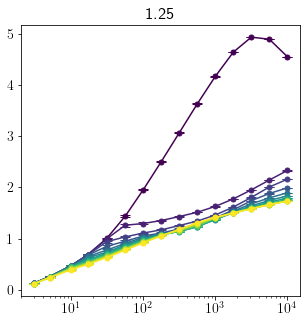

<Figure size 432x288 with 0 Axes>

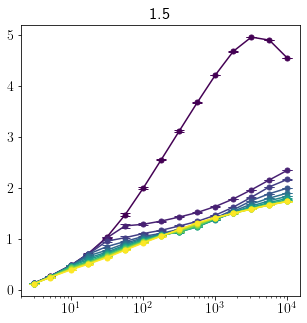

<Figure size 432x288 with 0 Axes>

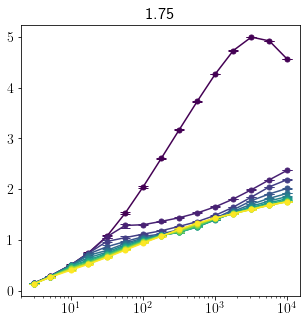

<Figure size 432x288 with 0 Axes>

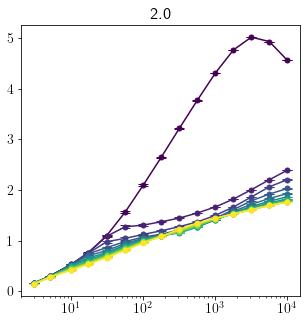

<Figure size 432x288 with 0 Axes>

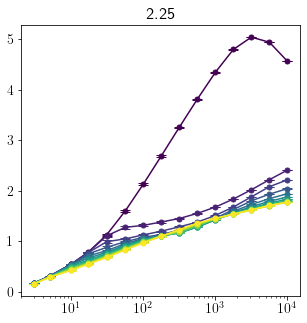

<Figure size 432x288 with 0 Axes>

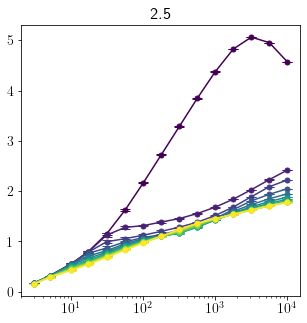

<Figure size 432x288 with 0 Axes>

In [6]:
for kT in range(len(T_range)):
    colors_ = plt.cm.viridis(np.linspace(0,1,12))
    plt.figure(figsize=(5,5))
    plt.title(T_range[kT])
    for k in range(12):
        mean = np.mean(h_T_K_s[kT,k,:,:].T,axis=0)
        cil = np.percentile(h_T_K_s[kT,k,:,:].T,2.5,axis=0)
        ciu = np.percentile(h_T_K_s[kT,k,:,:].T,97.5,axis=0)
        plt.errorbar(seed_range,mean,yerr = [mean-cil,ciu-mean],capsize=5,marker='o',ms=5,c=colors_[k])
    plt.xscale('log')
#     plt.savefig('Embedding_DW_T_{}.pdf'.format(T_range[kT]))
    plt.show()
    plt.clf()

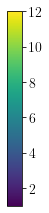

In [7]:
import pylab as pl
import numpy as np

a = np.array([[0,1]])
pl.figure(figsize=(.25, 4.5))
img = pl.imshow(a, cmap="viridis",vmin=1,vmax=12)
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
pl.colorbar(cax=cax)
plt.show()
# pl.savefig("colorbar_Krange.pdf")

# FigS1a

In [8]:
Tmin=0
scaled_T = (T_range - Tmin) / T_range.ptp()

colors_ = plt.cm.Reds(scaled_T)

In [9]:
hdiff = -np.diff(h_T_K_s,axis=1)/dt

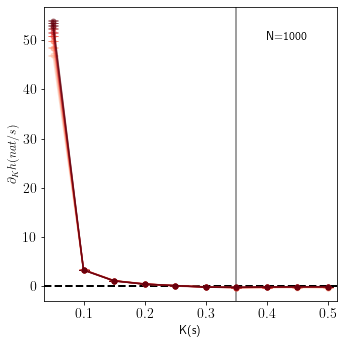

In [10]:
ks = 10
plt.figure(figsize=(5,5))
for kt in range(len(T_range)):
    mean,cil,ciu = stats.bootstrap(hdiff[kt][:10,ks,:].T,n_times=100)
    plt.errorbar(K_range[:10]*dt,mean,[mean-cil,ciu-mean],marker='o',capsize=5,ms=5,c=colors_[kt],alpha=.5)
plt.axhline(0,ls='--',c='k',lw=2)
plt.xlim(0.035,0.515)
plt.xlabel('K(s)',fontsize=12)
plt.axvline(7*dt,c='gray')
plt.ylabel('$\partial_K h (nat/s)$',fontsize=12)
plt.text(.4,50,'N={}'.format(seed_range[ks]),fontsize=12)
plt.tight_layout()
# plt.savefig('h_diff_DW.pdf')
plt.show()

# FigS3b

In [11]:
def bootstrap(l,n_times,n_samples,confidence_interval=95):
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        new_list=np.random.choice(l,n_samples,replace=True)
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return ma.mean(l,axis=0),cil,ciu

In [12]:
import findiff


mean_E_kin_phspace = np.zeros((len(T_range),3))
for kt,k_B_T in enumerate(T_range):
    f = h5py.File(dir_path+'DoubleWell/embedding/phspace_k_B_T_{}.h5'.format(k_B_T),'r')
    traj_matrix = np.array(f['traj_matrix'])
    f.close()
    f = h5py.File(dir_path+'DoubleWell/simulations/simulation_k_B_T_{}.h5'.format(k_B_T),'r')
    sim = np.array(f['simulation'])
    f.close()

    coefs = findiff.coefficients(deriv=1, acc=6)
    deriv_array = coefs['center']['coefficients']
    
    v_estim = (traj_matrix.dot(deriv_array))/dt
    mean_E_kin_phspace[kt] = bootstrap((v_estim**2)/2,n_times=1000,n_samples=10000)
    print(k_B_T,mean_E_kin_phspace[kt])

<ipython-input-12-f36e1f5ac3bf>:17: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  mean_E_kin_phspace[kt] = bootstrap((v_estim**2)/2,n_times=1000,n_samples=10000)


0.5 [0.24580872 0.23904468 0.25276352]
0.75 [0.36877045 0.35904312 0.37921131]
1.0 [0.49194087 0.4780513  0.50577182]
1.25 [0.61557392 0.59900283 0.63246144]
1.5 [0.73807404 0.71652361 0.7587301 ]
1.75 [0.86124886 0.83761462 0.88590916]
2.0 [0.98400078 0.95638825 1.01234911]
2.25 [1.10472636 1.0744217  1.13520396]
2.5 [1.23222654 1.19715222 1.26579757]


(2, 9)


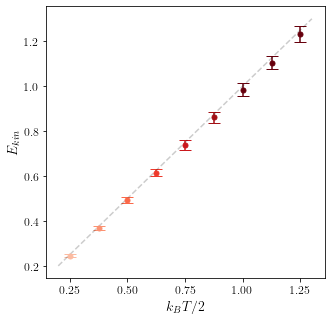

In [13]:
Tmin=0
scaled_T = (T_range - Tmin) / T_range.ptp()

colors_ = plt.cm.Reds(scaled_T)

plt.figure(figsize=(5,5))

y_err = np.array([mean_E_kin_phspace[:,0]-mean_E_kin_phspace[:,1],mean_E_kin_phspace[:,2]-mean_E_kin_phspace[:,0]])
print(y_err.shape)
kt=0
for kt in range(len(T_range)):
    plt.errorbar(T_range[kt]/2,mean_E_kin_phspace[kt,0],yerr = [[y_err[0][kt]],[y_err[1][kt]]],fmt='o',capsize=6,
             ms=5,c=colors_[kt])
plt.plot(np.arange(.2,1.4,.1),np.arange(.2,1.4,.1),ls='--',c='k',alpha=.2)
plt.xlabel('$k_BT/2$',fontsize=14)
plt.ylabel(r'$E_{kin}$',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('equipartition_K_6_order_6_withT.pdf')
plt.show()

# FigS3c

In [19]:
np.random.seed(1)
u,s,v = np.linalg.svd(traj_matrix,full_matrices=False)

In [15]:
bootstrap_s = []
for k in range(100):
    random_indices = np.random.randint(0,len(traj_matrix),len(traj_matrix))
    _,s_,_ = np.linalg.svd(traj_matrix[random_indices],full_matrices=False)
    bootstrap_s.append(s_)
    print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [16]:
bootstrap_s = np.array(bootstrap_s)
cum_sum_boot = (np.cumsum(bootstrap_s**2,axis=1).T/np.sum(bootstrap_s**2,axis=1)).T
std = np.std(cum_sum_boot,axis=0)

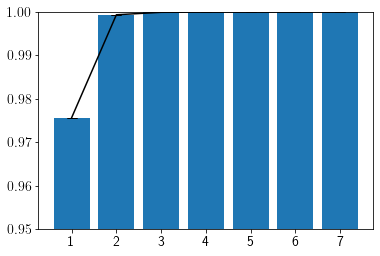

In [17]:
plt.bar(range(len(s)),np.cumsum(s**2)/np.sum(s**2),yerr = std,capsize=5)
plt.ylim(0.95,1)
plt.plot(range(len(s)),np.cumsum(s**2)/np.sum(s**2),c='k')
plt.xticks(np.arange(7),np.arange(1,8))
# plt.xlabel('# svd modes')
# plt.ylabel('cumsum(s^2)')
# plt.savefig('svd_spectrum.pdf')
plt.show()

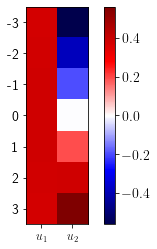

In [22]:
plt.imshow(v[:2,::-1].T,cmap='seismic',extent=[-0.5,1.5,-0.5,6.5])
plt.xticks([0,1],['$u_1$','$u_2$'],fontsize=12)
plt.yticks(np.arange(0,7),np.arange(-3,4)[::-1])
plt.colorbar()
# plt.savefig('svd_modes.pdf')
plt.show()

# Fig2a - bottom panel

In [9]:
f = h5py.File(dir_path+'/DoubleWell/example_P_sims/sims_T_0.5_K_1_N_1000.h5','r')
sims_K_1 = np.array(f['sims'])
twindow = np.array(f['MetaData/twindow'])
f.close()
f = h5py.File(dir_path+'/DoubleWell/example_P_sims/sims_T_0.5_K_7_N_1000.h5','r')
sims_K_7 = np.array(f['sims'])
f.close()

<KeysViewHDF5 ['delay', 'twindow']>


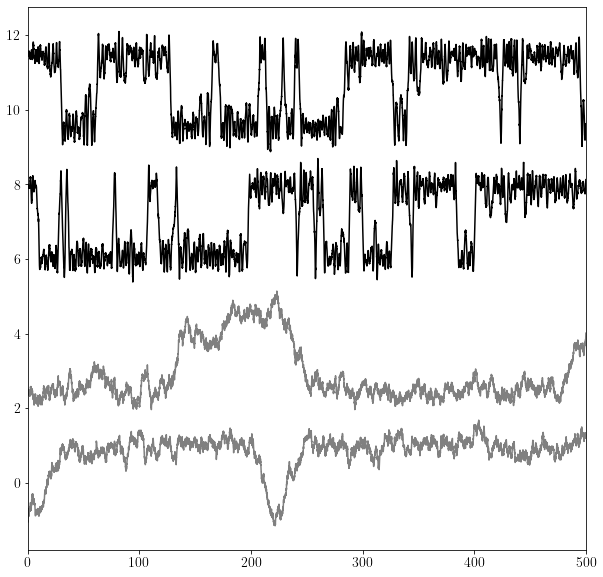

In [20]:
plt.figure(figsize=(10,10))
for k in range(2,4):
    plt.plot(np.arange(twindow)*dt,sims_K_7[k]+3.5*k,c='k')
for k in range(0,2):
    plt.plot(np.arange(twindow)*dt,sims_K_1[k]+3.5*k,c='gray')
plt.xlim(0,500)
plt.show()